In [1]:
from tensorflow_probability import edward2 as ed
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import inferpy as inf 

/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

In [2]:
D = 2
K = 2
N = 1000

In [3]:
###### DATA SAMPLES ######
# Define two normal distribution
aux1 = inf.models.Normal(loc=tf.ones([D])*1, scale = 1)
aux2 = inf.models.Normal(loc=tf.ones([D])*10, scale = 1)
# Stack 300 samples from the first and 700 from the second
x = np.vstack([aux1.sample(300), aux2.sample(700)])
np.random.shuffle(x)

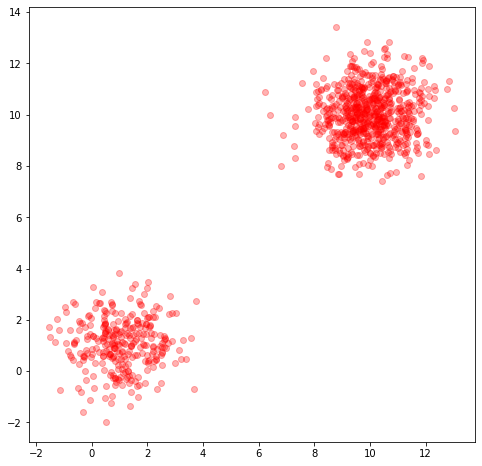

In [4]:
plt.figure(figsize=(8, 8))
plt.plot(x[:,0],x[:,1],'ro',alpha=0.3)
plt.show()

In [5]:
# Gaussiam Mixture Model
@inf.probmodel
def gaussian_mixture(N, K, D, m0, b0, w0, v0, alpha0):
    pi = inf.Dirichlet(np.ones(K)*alpha0, name="pi")
    with inf.datamodel(K):
        sigma = inf.InverseGamma(concentration = tf.ones(D)*w0, scale = v0, name="lambda")
        mu = inf.Normal(tf.ones(D)*m0, b0*sigma, name="mu")
    with inf.datamodel(N):
        z = inf.Categorical(probs = pi, name="z")
        x = inf.Normal(tf.gather(mu,z), tf.gather(sigma,z), name="x")

m = gaussian_mixture(N = N, K = K, D = D, m0 = 1, b0 = 1, w0 = 1, v0 = 1, alpha0 = 1)

In [6]:
m.prior().parameters()

{'pi': {'name': 'pi',
  'allow_nan_stats': True,
  'validate_args': False,
  'concentration': array([1., 1.], dtype=float32)},
 'sigma': {'name': 'sigma',
  'rate': None,
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': 1,
  'concentration': array([1., 1.], dtype=float32)},
 'mu': {'name': 'mu',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[0.9283134, 1.9943813],
         [6.074078 , 2.2575114]], dtype=float32),
  'loc': array([1., 1.], dtype=float32)},
 'z': {'name': 'z',
  'allow_nan_stats': True,
  'validate_args': False,
  'dtype': tf.int32,
  'probs': array([0.55464953, 0.4453505 ], dtype=float32),
  'logits': None},
 'x': {'name': 'x',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[1.2977301, 3.0367982],
         [1.2977301, 3.0367982],
         [1.2977301, 3.0367982],
         ...,
         [4.584197 , 1.7800069],
         [1.2977301, 3.0367982],
         [1.2977301, 3.0367982]], dtype=float32),
  'loc': array([[ 

(1000, 2)


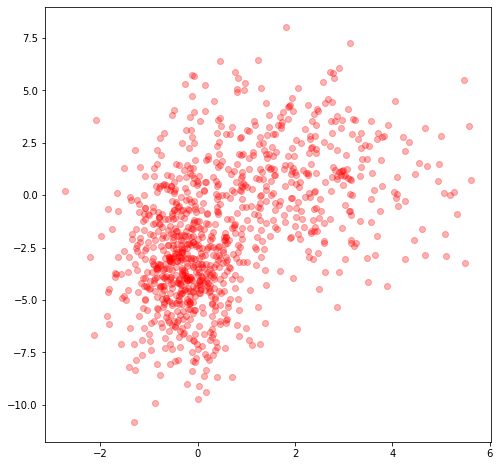

In [7]:
# Show a sample from the model
aux_sample = m.prior("x").sample(1)
print(aux_sample.shape)
plt.figure(figsize=(8, 8))
plt.plot(aux_sample[:,0], aux_sample[:,1],'ro',alpha=0.3)
plt.show()

In [8]:
@inf.probmodel
def qmodel(K,D):
    qpi_param = inf.Parameter(tf.ones([K]), name="qpi_param")
    qpi = inf.Dirichlet(qpi_param, name="pi")
    with inf.datamodel(K):
        qsigma_w = inf.Parameter(tf.ones([D]), name="qlambda_w")
        qsigma_v = inf.Parameter(tf.ones([D]), name="qlambda_v")
        sigma = inf.InverseGamma(concentration = qsigma_w, scale = qsigma_v, name="sigma")
        
        qmu_m = inf.Parameter(tf.ones([D]), name="qmu_m")
        qmu_b = inf.Parameter(tf.ones([D]), name="qmu_b")
        qmu = inf.Normal(qmu_m, qmu_b, name="mu")
        
    with inf.datamodel():
        qz_param = inf.Parameter(tf.ones([K]), name="qz_param")
        qz = inf.Categorical(probs = qz_param, name="z")
        
qmodel(K,D).prior().sample()

OrderedDict([('pi', array([0.50660175, 0.49339825], dtype=float32)),
             ('sigma',
              array([[0.6310731 , 2.3792694 ],
                     [1.6884624 , 0.90378547]], dtype=float32)),
             ('mu',
              array([[-0.18604684,  1.7990289 ],
                     [-0.7463392 , -0.66304445]], dtype=float32)),
             ('z', array([0], dtype=int32))])

In [11]:
q = qmodel(K,D)
VI = inf.inference.VI(q, epochs=2000)
m.fit({"x": x}, VI)

/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/inferpy/models/prob_model.py:187: UserWarning: Fit was called before. This will restart the inference method and                 re-build the expanded model.
  re-build the expanded model.")



 0 epochs	 125573.96875....................
 200 epochs	 12656.0302734375....................
 400 epochs	 43439.59375....................
 600 epochs	 8799.6083984375....................
 800 epochs	 39836.21875....................
 1000 epochs	 25848.228515625....................
 1200 epochs	 24663.560546875....................
 1400 epochs	 14488.1357421875....................
 1600 epochs	 27491.744140625....................
 1800 epochs	 7669.970703125....................

In [12]:
m.posterior().parameters()

{'pi': {'name': 'pi',
  'allow_nan_stats': True,
  'validate_args': False,
  'concentration': array([1.2781054, 1.2617015], dtype=float32)},
 'sigma': {'name': 'sigma',
  'rate': None,
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[1.3170034, 1.3342452],
         [1.3146114, 1.3561404]], dtype=float32),
  'concentration': array([[0.4963404 , 0.47087222],
         [0.47402415, 0.45867598]], dtype=float32)},
 'mu': {'name': 'mu',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[0.9973084, 0.9212224],
         [0.9730171, 0.9392838]], dtype=float32),
  'loc': array([[1.3564892, 1.3641485],
         [1.3431134, 1.3948488]], dtype=float32)},
 'z': {'name': 'z',
  'allow_nan_stats': True,
  'validate_args': False,
  'dtype': tf.int32,
  'probs': array([[1.095587  , 0.90173346]], dtype=float32),
  'logits': None}}